# OCR Projeto 02: Escaneamento de imagem

# Importando as bibliotecas

In [151]:
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt

# Conectando com o Google Drive

In [152]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Processamentos na imagem (para transformação)

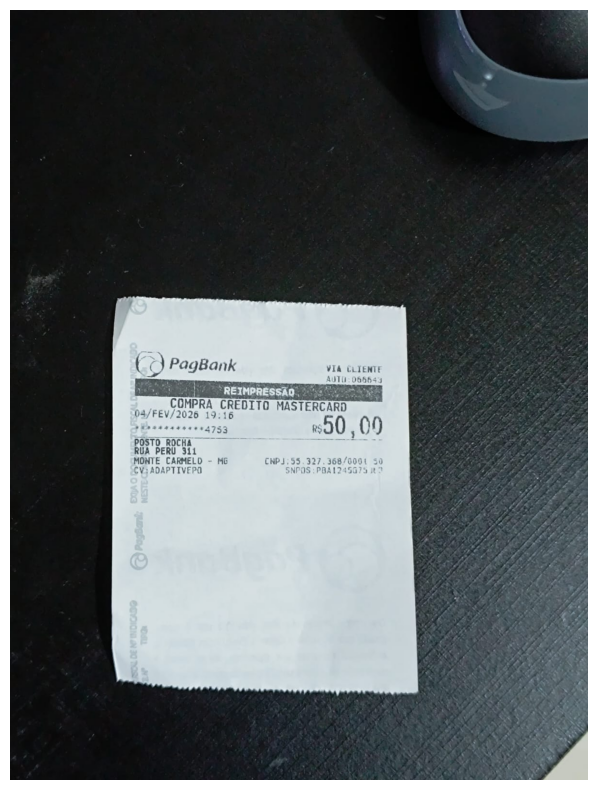

1600 1200


In [153]:
img = cv2.imread('comp02.jpeg')
original = img.copy()
mostrar(img)
(H, W) = img.shape[:2]
print(H, W)

## Conversão para tons de cinza (*grayscale*)

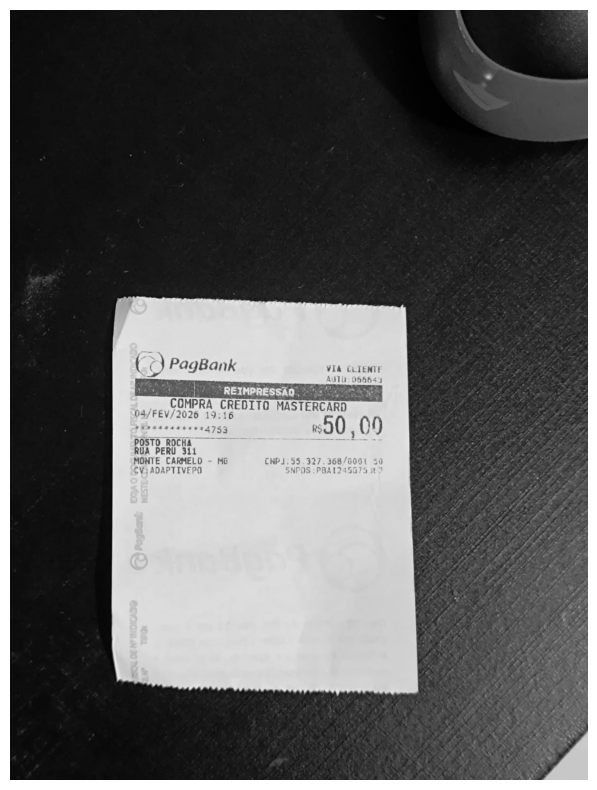

In [154]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mostrar(gray)

## Aplicação de desfoque (*Gaussian Blur*)

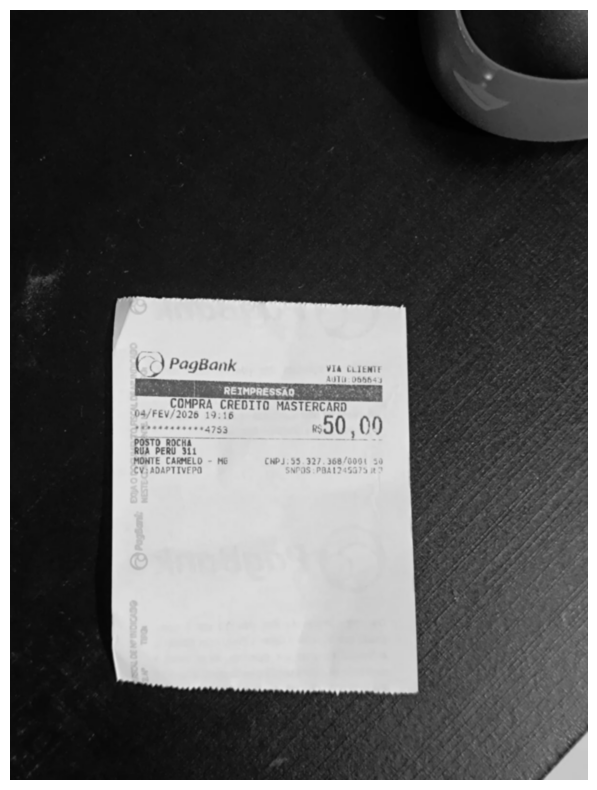

In [155]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
mostrar(blur)

## Detecção de bordas (*Canny Edge*)

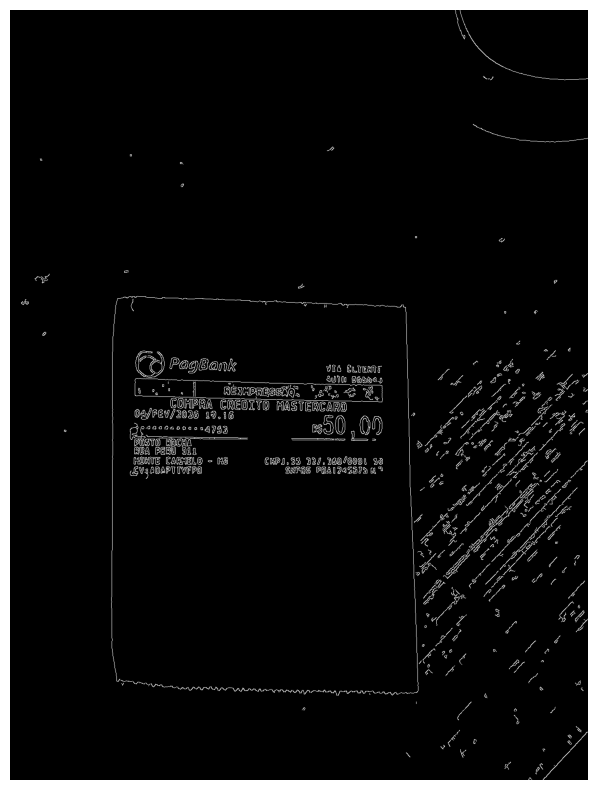

In [190]:
edged = cv2.Canny(blur, 60, 160)
mostrar(edged)

# Detecção de contornos na imagem

In [205]:
def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts

In [235]:
conts = encontrar_contornos(edged.copy())

In [236]:
conts

[array([[[262, 765]],
 
        [[261, 766]],
 
        [[260, 766]],
 
        [[260, 767]],
 
        [[259, 768]],
 
        [[259, 771]],
 
        [[260, 772]],
 
        [[260, 774]],
 
        [[259, 775]],
 
        [[259, 800]],
 
        [[260, 801]],
 
        [[262, 801]],
 
        [[263, 802]],
 
        [[264, 801]],
 
        [[274, 801]],
 
        [[275, 802]],
 
        [[307, 802]],
 
        [[308, 803]],
 
        [[342, 803]],
 
        [[343, 804]],
 
        [[350, 804]],
 
        [[351, 803]],
 
        [[352, 804]],
 
        [[376, 804]],
 
        [[377, 805]],
 
        [[378, 804]],
 
        [[381, 804]],
 
        [[382, 805]],
 
        [[383, 804]],
 
        [[385, 804]],
 
        [[386, 805]],
 
        [[406, 805]],
 
        [[407, 806]],
 
        [[438, 806]],
 
        [[439, 807]],
 
        [[440, 806]],
 
        [[445, 806]],
 
        [[446, 807]],
 
        [[477, 807]],
 
        [[478, 808]],
 
        [[479, 808]],
 
        [[480, 8

## Localizando o maior contorno

- Douglas-Peucker: http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm

In [237]:
for c in conts:
  perimetro = cv2.arcLength(c, True)
  aproximacao = cv2.approxPolyDP(c, 0.02 * perimetro, True)
  if len(aproximacao) == 4:
    maior = aproximacao
    break

In [238]:
maior

array([[[259, 768]],

       [[263, 802]],

       [[773, 811]],

       [[768, 779]]], dtype=int32)

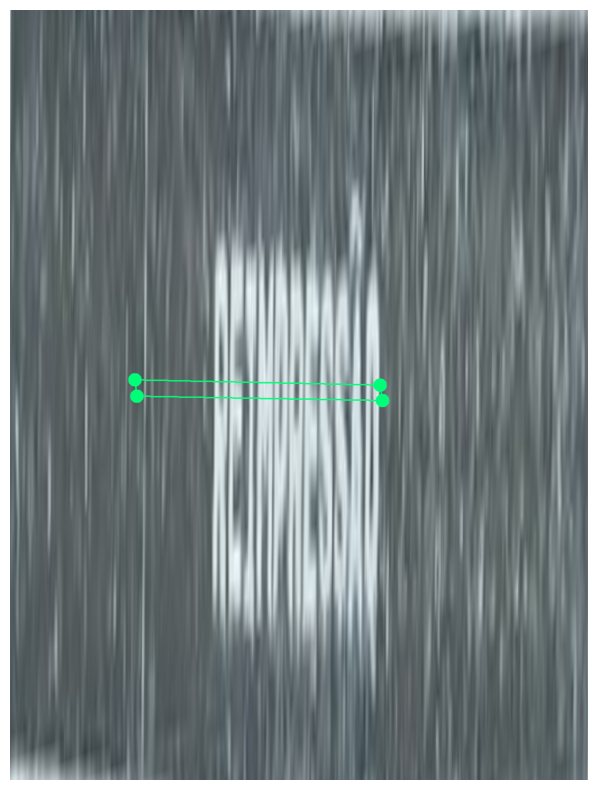

In [239]:
cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
mostrar(img)

## Ordenando os pontos

Nós ja temos as 4 coordenadas x-y que correspondem aos cantos do retângulo/polígono localizado na imagem, porém esses pontos provavelmente estarão fora de uma ordem. Para fazer a transformação de perspectiva precisamos ordenar os pontos, de modo que eles fiquem em uma ordem padrão e assim seja possível aplicar a transformação.

É crucial que a ordem dos pontos do retângulo esteja consistente em todo o programa. Pois caso mude de ordem algum desses pontos a transformação não vai ficar da forma que queremos.

Nós escolhemos essa ordem:

1. **te** = topo esquerdo (superior esquerdo)
2. **td** = topo direito (superior direito)
3. **bd** = baixo direito (inferior direito)
4. **be** = baixo esquerdo (inferior esquerdo)

Preferimos deixar nessa ordem por ser um padrão mais utilizado. Você poderia se quiser mudar a ordem, deixar por exemplo `be` antes de `bd` e após `td`, só que se for fazer assim precisa manter essa ordem no restante do programa (especificamente na parte do pts2 que veremos abaixo, trocando o [W, H] por [0, H])

In [240]:
def ordenar_pontos(pontos):
  pontos = pontos.reshape((4,2))
  pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

  add = pontos.sum(1)
  pontos_novos[0] = pontos[np.argmin(add)]
  pontos_novos[2] = pontos[np.argmax(add)]

  dif = np.diff(pontos, axis = 1)
  pontos_novos[1] = pontos[np.argmin(dif)]
  pontos_novos[3] = pontos[np.argmax(dif)]

  return pontos_novos

In [241]:
pontos_maior = ordenar_pontos(maior)
print(pontos_maior)

[[[259 768]]

 [[768 779]]

 [[773 811]]

 [[263 802]]]


In [242]:
maior

array([[[259, 768]],

       [[263, 802]],

       [[773, 811]],

       [[768, 779]]], dtype=int32)

## Obtenção da matriz de transformação

In [243]:
pts1 = np.float32(pontos_maior)

In [244]:
pts1

array([[[259., 768.]],

       [[768., 779.]],

       [[773., 811.]],

       [[263., 802.]]], dtype=float32)

In [245]:
print(H, W)

1600 1200


In [246]:
pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])

In [247]:
matriz = cv2.getPerspectiveTransform(pts1, pts2)
matriz

array([[ 2.31182231e+00, -2.71979096e-01, -3.89882034e+02],
       [-1.06305240e+00,  4.91903340e+01, -3.75028459e+04],
       [-1.23520292e-04,  9.36693297e-05,  1.00000000e+00]])

## Transformação de perspectiva

In [248]:
transform = cv2.warpPerspective(original, matriz, (W, H))

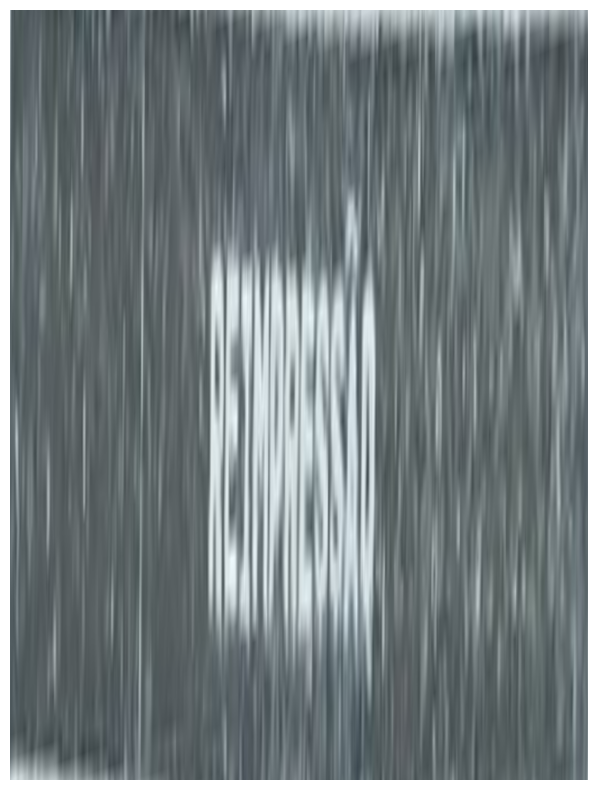

In [249]:
mostrar(transform)

# OCR com Tesseract

In [250]:
import pytesseract

In [251]:
config_tesseract = "--tessdata-dir tessdata --psm 6"
texto = pytesseract.image_to_string(transform, lang="por", config=config_tesseract)
print(texto)

|V ', ||
M * N



In [252]:
maior = cv2.resize(transform, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
texto = pytesseract.image_to_string(maior, lang="por", config=config_tesseract)
print(texto)

l ' l & | l! 'l
M | q,

" ' ,l.“
l |



# Melhoria na qualidade da imagem

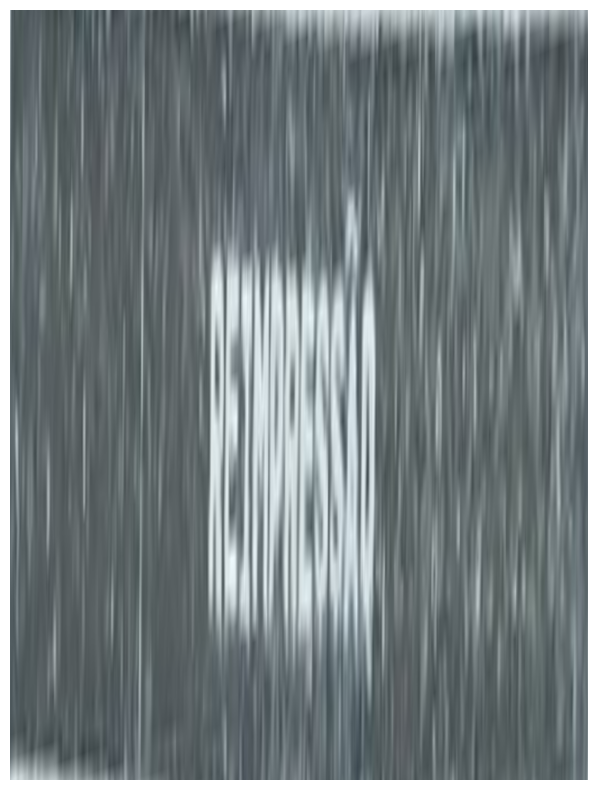

In [253]:
mostrar(transform)

In [254]:
transform.shape

(1600, 1200, 3)

## Aumentando o contraste e brilho

In [255]:
brilho = 50
contraste = 80
ajustes = np.int16(transform)
ajustes.shape

(1600, 1200, 3)

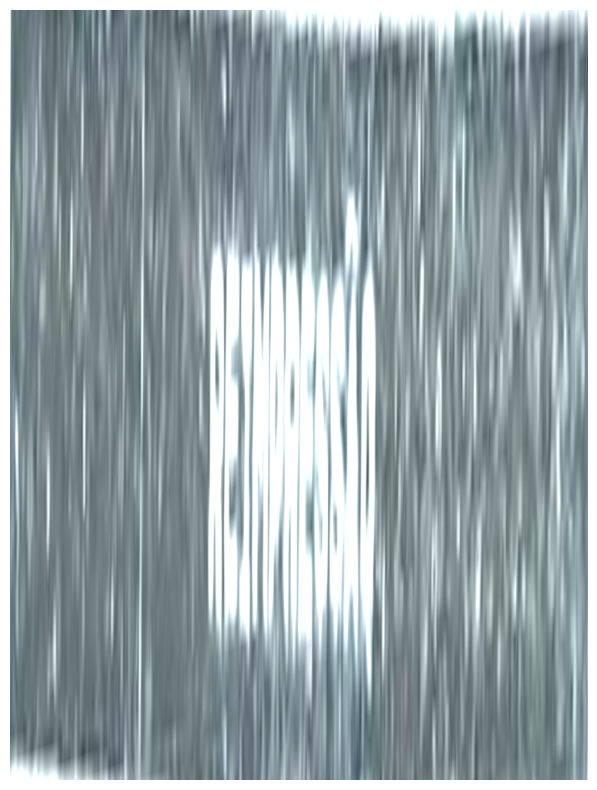

In [256]:
ajustes = ajustes * (contraste / 127 + 1) - contraste + brilho
ajustes = np.clip(ajustes, 0, 255)
ajustes = np.uint8(ajustes)
mostrar(ajustes)

## Limiarização Adaptativa

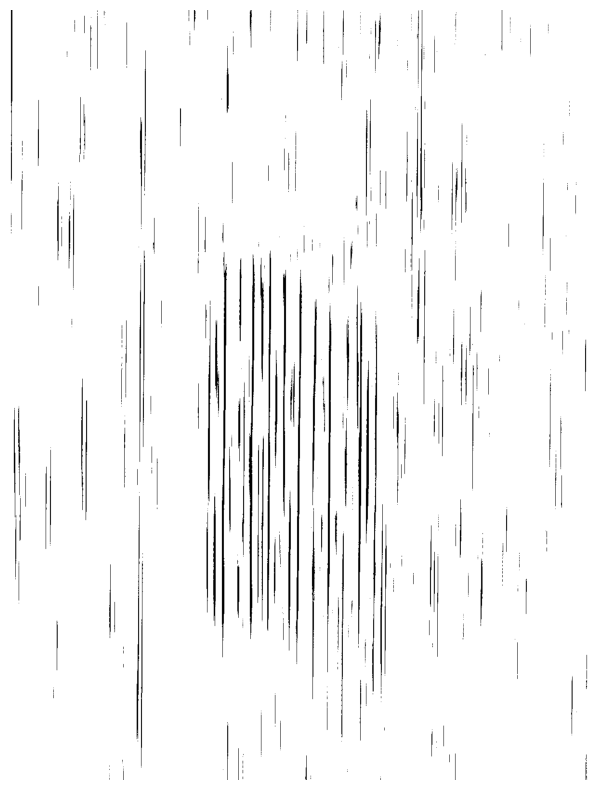

In [257]:
img_process = cv2.cvtColor(transform, cv2.COLOR_BGR2GRAY)
img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
mostrar(img_process)

## Remoção de bordas

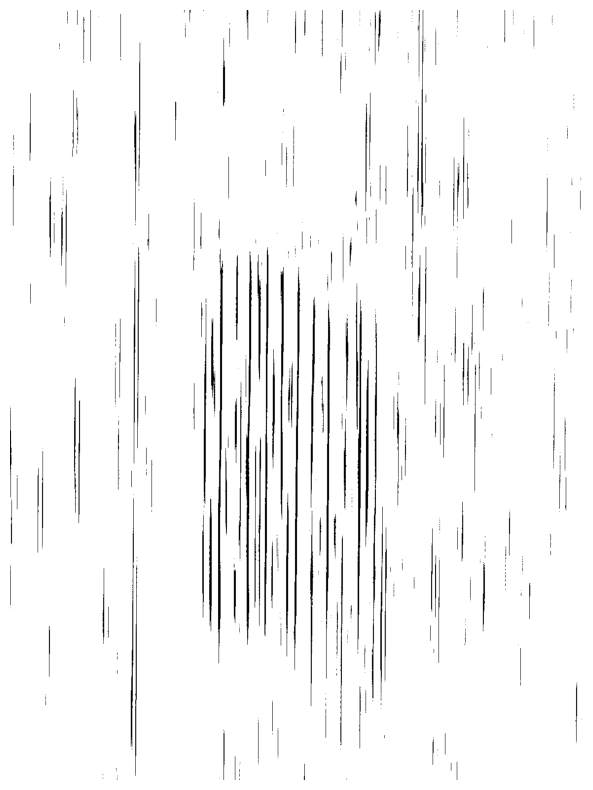

In [258]:
margem = 18
img_final = img_process[margem:H - margem, margem:W - margem]
mostrar(img_final)

## Comparativo

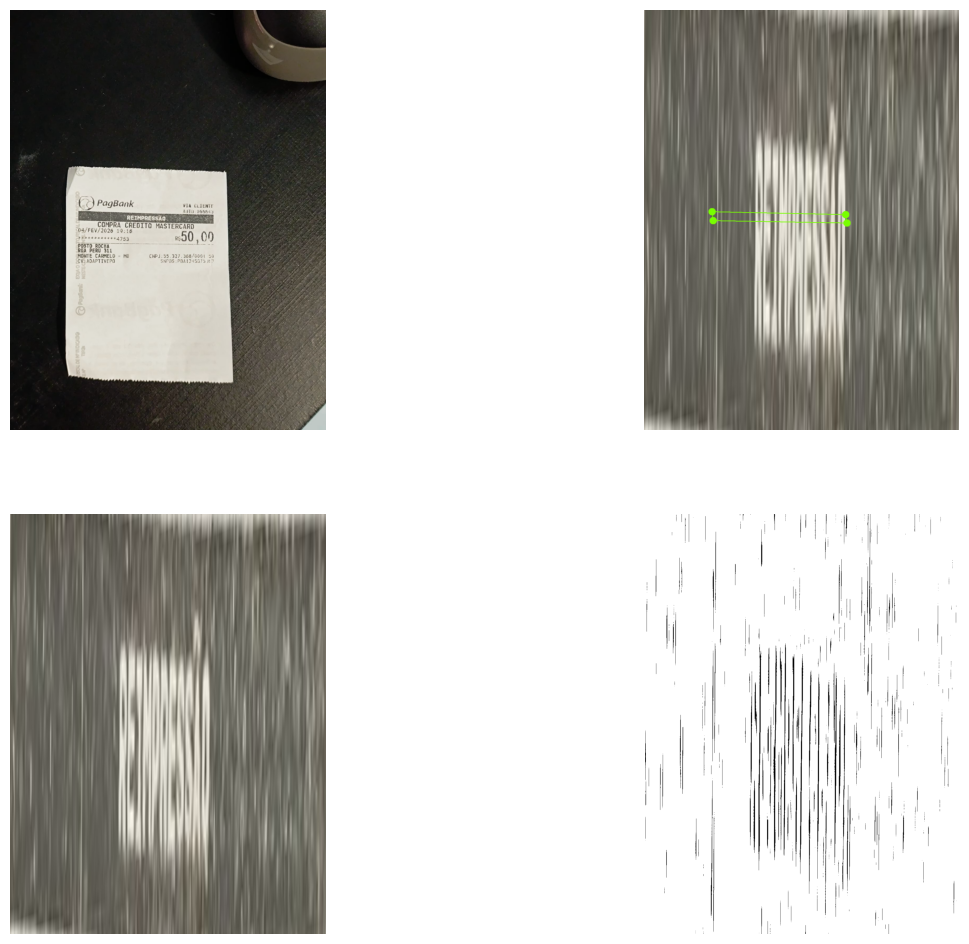

In [259]:
fig, im = plt.subplots(2, 2, figsize=(15,12))
for x in range(2):
  for y in range(2):
    im[x][y].axis('off')

im[0][0].imshow(original)
im[0][1].imshow(img)
im[1][0].imshow(transform, cmap='gray')
im[1][1].imshow(img_final, cmap='gray')
plt.show()

# Unindo as funções

In [260]:
def transform_imagem(nome_imagem):
  img = cv2.imread(nome_imagem)
  original = img.copy()
  mostrar(img)
  (H, W) = img.shape[:2]

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (7, 7), 0)
  edged = cv2.Canny(blur, 60, 160)
  mostrar(edged)
  conts = encontrar_contornos(edged.copy())
  for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(aprox) == 4:
      maior = aprox
      break

  cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
  cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
  mostrar(img)

  pontosMaior = ordenar_pontos(maior)
  pts1 = np.float32(pontosMaior)
  pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])

  matriz = cv2.getPerspectiveTransform(pts1, pts2)
  transform = cv2.warpPerspective(original, matriz, (W, H))

  mostrar(transform)
  return transform

In [261]:
def processamento_img(img):
  img_process = cv2.resize(img, None, fx=1.6, fy=1.6, interpolation=cv2.INTER_CUBIC)
  img_process = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
  return img_process

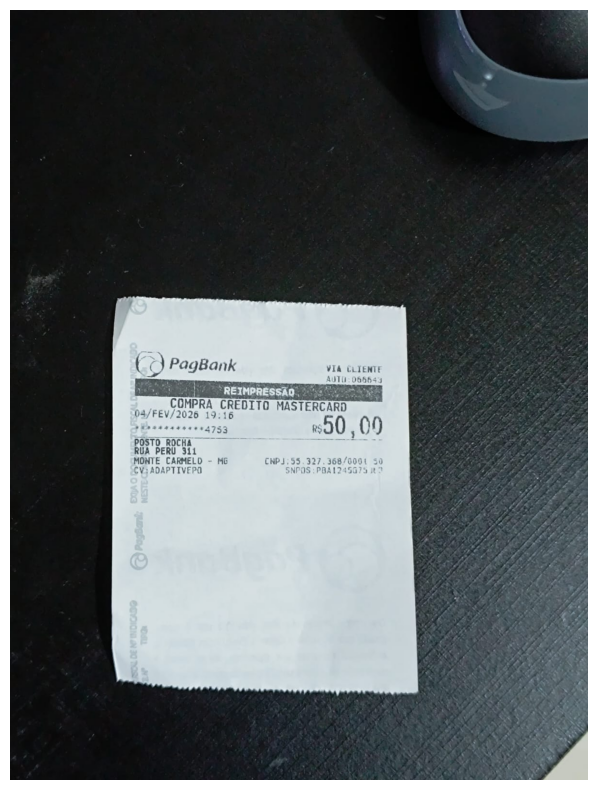

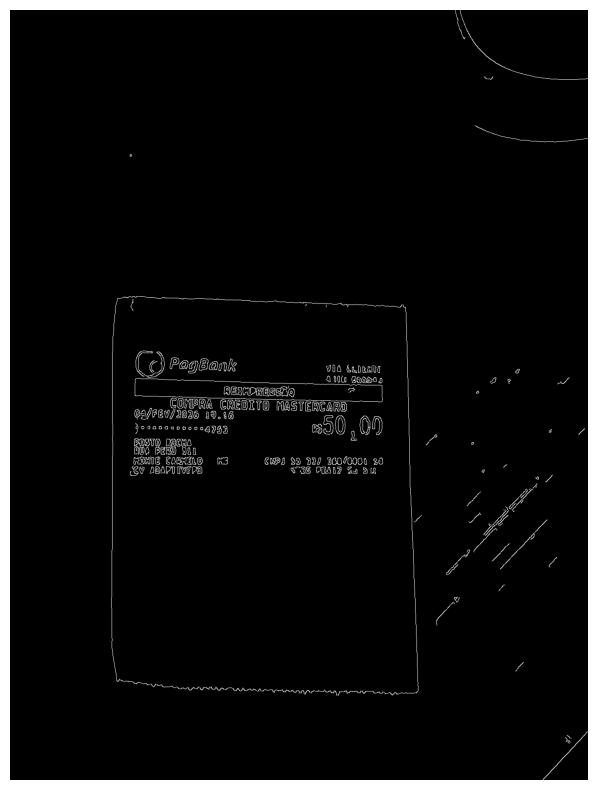

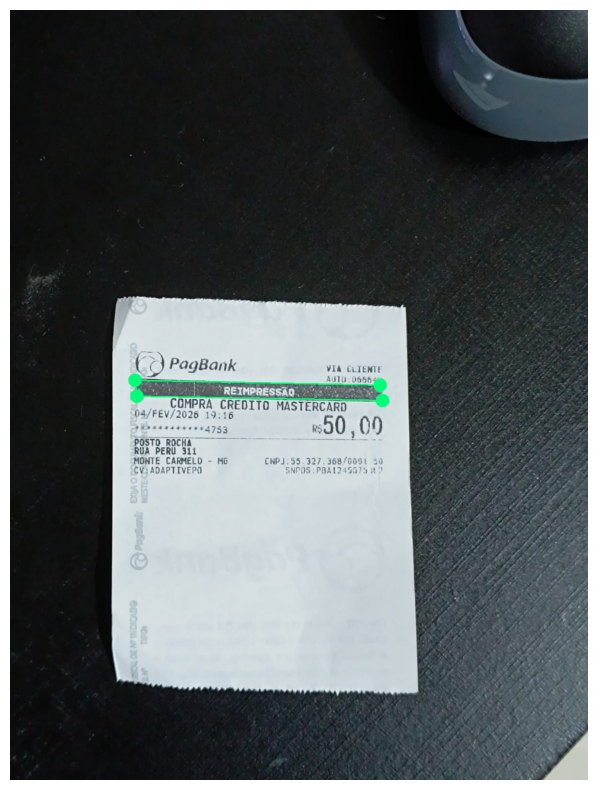

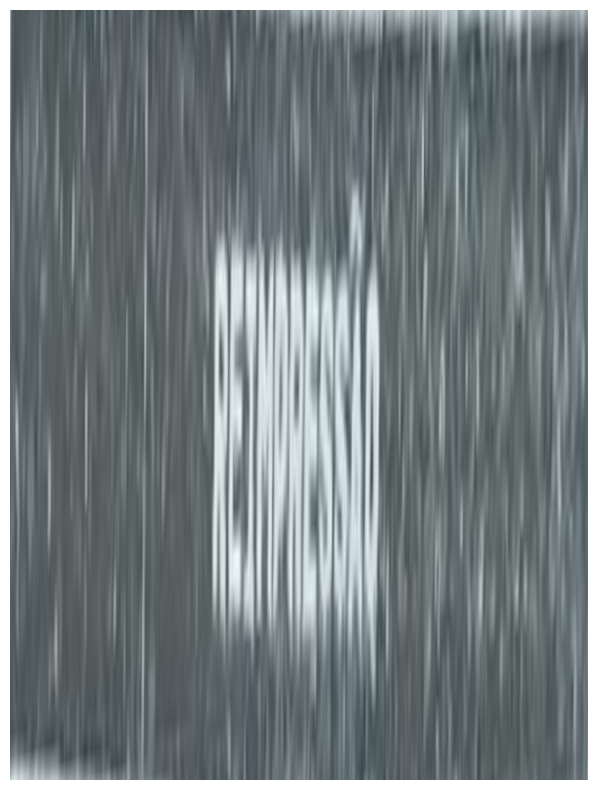

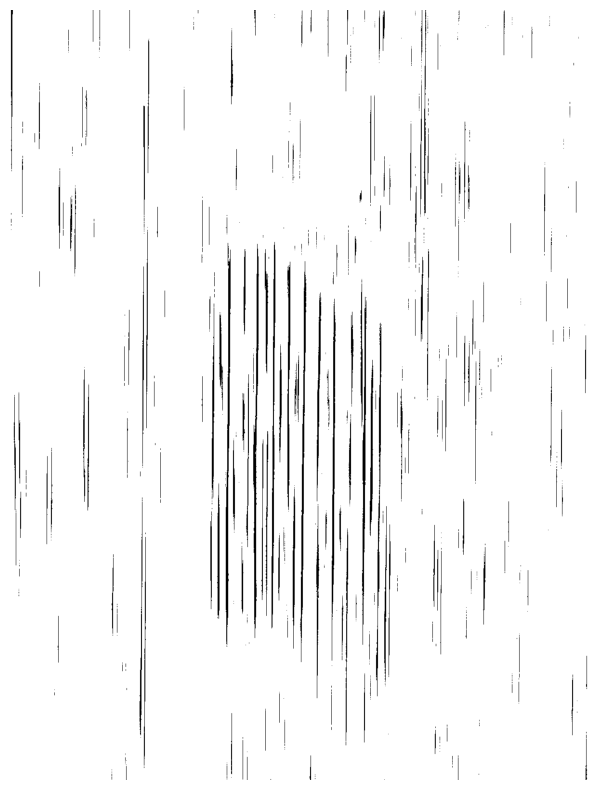

In [262]:
img = transform_imagem('comp02.jpeg')
img_final = processamento_img(img)
mostrar(img_final)

In [263]:
texto = pytesseract.image_to_string(img_final, lang="por", config=config_tesseract)
print(texto)

y
)

